In [1]:
import numpy as np
import pandas as pd

import pymc3 as pm

import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
N
\left(
0, 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
\right)
$$

$$
f_*|X, y, X_* 
\sim
N(\bar{f}_*, \text{cov}(f_*))
$$

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y
$$

$$
\text{cov}(f_*) = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*)
$$

In [2]:
# Define dimension.
d = 1

# Number of samples. 
n = 250

x = np.linspace(start=0, stop=1, num=n)

# Error standar deviation. 
sigma_n = 0.4

# Errors.
epsilon = np.random.normal(loc=0, scale=sigma_n, size=n)

def f(x):
    
    f = np.sin((2*np.pi)*x) + np.sin((4*np.pi)*x)
    
    return(f)

f = f(x)

# Observer target variable. 
y = f + epsilon

/Users/juanitorduz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


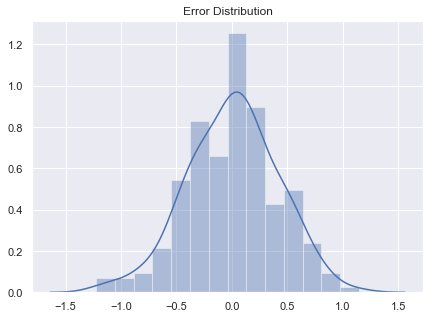

In [3]:
fig, ax = plt.subplots(figsize=(7,5))
# Plot errors. 
sns.distplot(epsilon)

ax.set_title("Error Distribution");

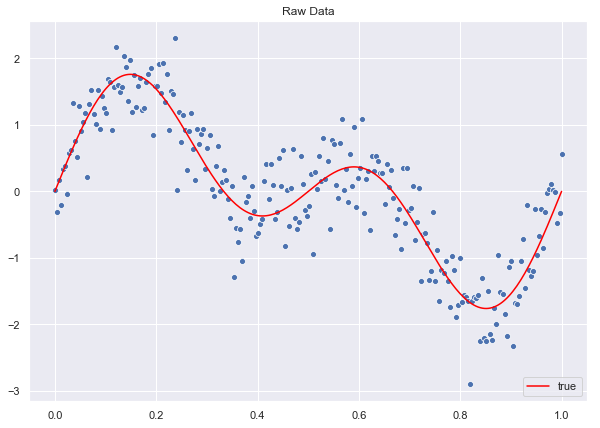

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot raw data.
sns.scatterplot(x=x, y=y);
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

In [5]:
n_star = 50

x_star = np.linspace(start=0, stop=1, num=n_star)

In [6]:
def kernel_function(x, y, sigma_f=1, l=1):
    
    c = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    
    return c

In [7]:
l = 0.1
sigma_f = 2

In [8]:
import itertools

def compute_cov_matrices(x, x_star, sigma_f = 1, l =1):

    """Compute components of the covariance matrix of the join distribution."""
    
    n = x.shape[0]
    n_star = x_star.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x, x)]

    K = np.array(K).reshape(n, n) + (sigma_n**2)*np.eye(n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x_star)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(x_star, x)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [9]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l =l)

In [10]:
K.shape

(250, 250)

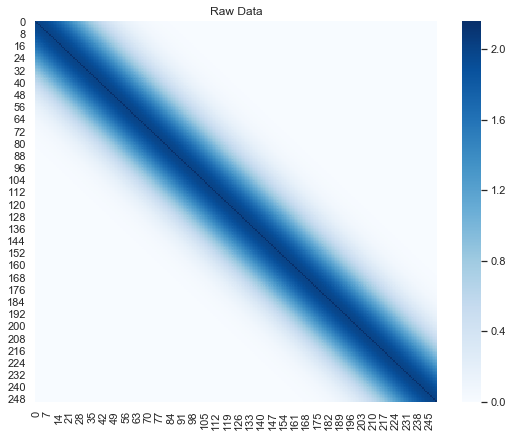

In [11]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K, cmap="Blues", ax=ax)

ax.set_title("Raw Data");

In [12]:
K_star2.shape

(50, 50)

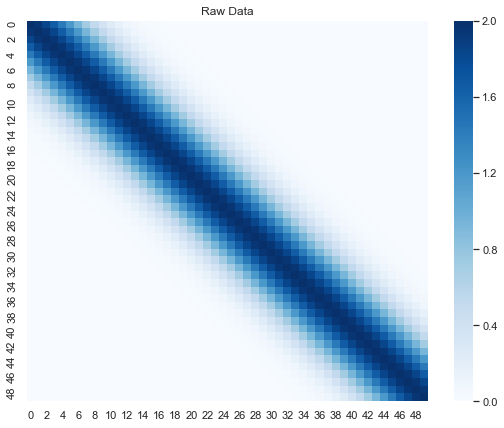

In [13]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K_star2, cmap="Blues", ax=ax)

ax.set_title("Raw Data");

In [14]:
K_star.shape

(50, 250)

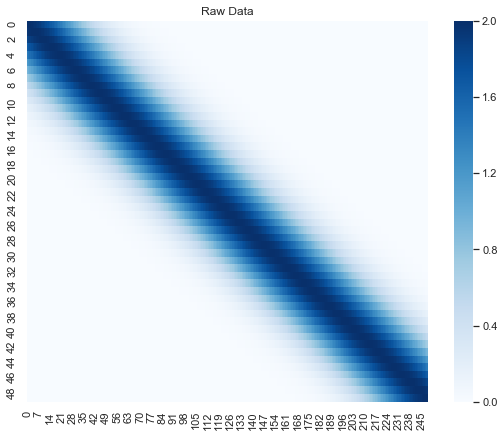

In [15]:
fig, ax = plt.subplots(figsize=(9,7))

sns.heatmap(data=K_star, cmap="Blues", ax=ax)

ax.set_title("Raw Data");

In [16]:
a = np.concatenate((K, K_star), axis=0)
a.shape

(300, 250)

In [17]:
b = np.concatenate((K_star.T, K_star2), axis=0)
b.shape

(300, 50)

In [18]:
C = np.concatenate((a, b), axis=1)
C.shape

(300, 300)

In [19]:
np.all(C.T == C)

True

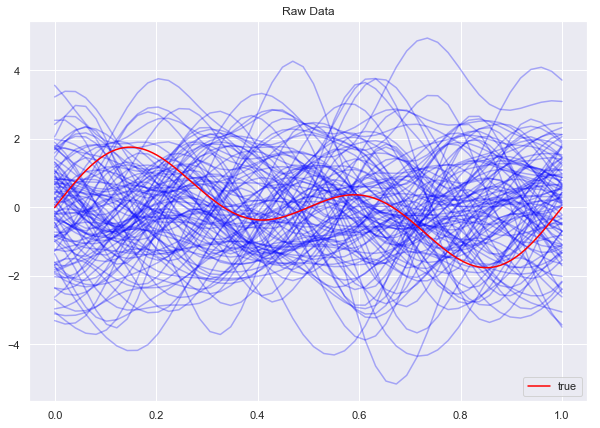

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
# Plot raw data.

for i in range(0, 100):
    
    z_star = np.random.multivariate_normal(mean=np.zeros(n_star), cov=K_star2)

    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.3);
    
# Plot "true" linear fit.
sns.lineplot(x=x.T.reshape(n,), y=f.reshape(n,), color="red", label = "true");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

In [21]:
def compute_gpr_parameters(K, K_star2, K_star):
    
    """Compute gaussian regression parameters."""
    
    f_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K), y.reshape([n, d])))
    
    cov_f_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K), K_star.T))
    
    return (f_bar_star, cov_f_star)

In [22]:
f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star)

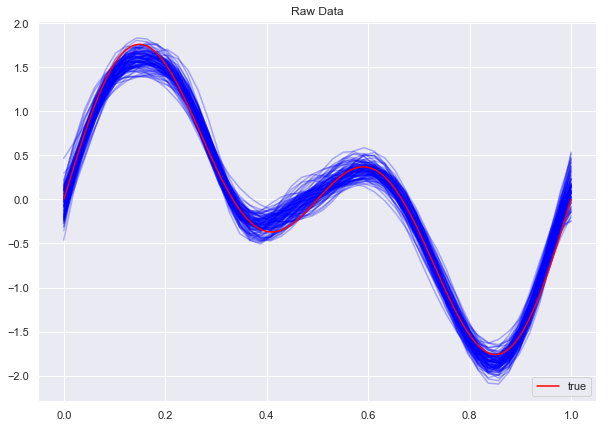

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.3);
    

# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

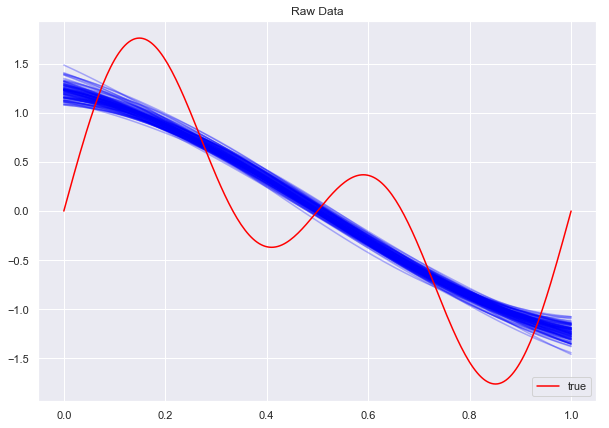

In [24]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = 2, l = 1)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star)

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.3);

# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

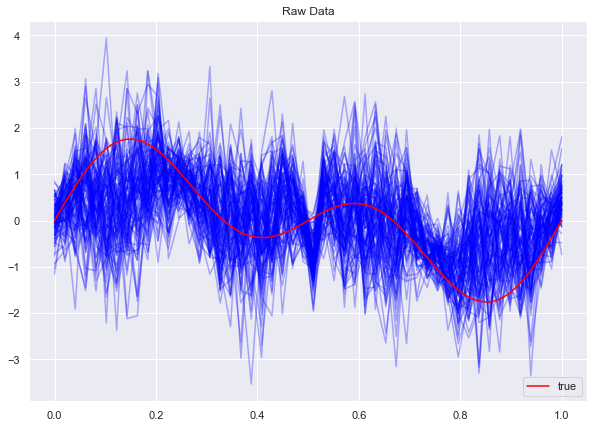

In [25]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = 1, l = 0.001)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star)

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.3);

# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

- https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

- https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html


In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Instantiate a Gaussian Process model
kernel = C(sigma_f) * RBF(length_scale = l)
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n, n_restarts_optimizer=9)

In [27]:
X = x.reshape(n, d)
X_star = x_star.reshape(n_star, d)

In [28]:
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_star, return_std=True)

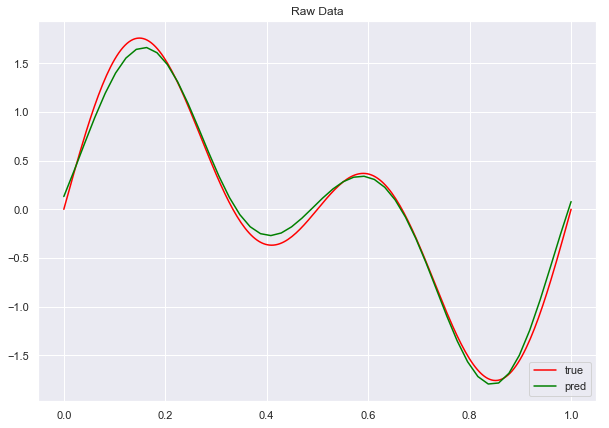

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
    
# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

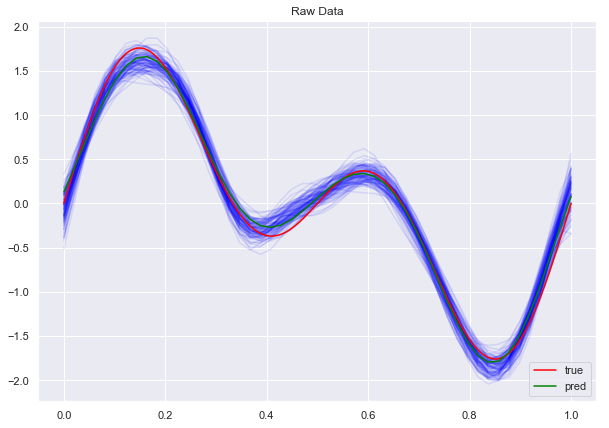

In [30]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star)

fig, ax = plt.subplots(figsize=(10, 7))

for i in range(0, 100):
    
    z_star = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star)
    
    sns.lineplot(x=x_star, y=z_star, color="blue", alpha=0.1);
    

# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");

ax.legend(loc="lower right")
ax.set_title("Raw Data");

In [31]:
y_hat_samples = np.random.multivariate_normal(mean=f_bar_star.squeeze(), cov=cov_f_star, size=100)

# Compute the standard deviation. 
y_hat = np.apply_over_axes(func=np.mean, a=y_hat_samples, axes=0).squeeze()

# Compute the standard deviation. 
y_hat_sd = np.apply_over_axes(func=np.std, a=y_hat_samples, axes=0).squeeze()

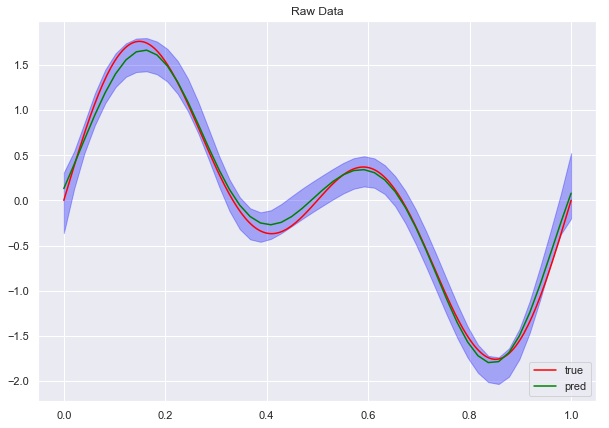

In [34]:
K, K_star2, K_star = compute_cov_matrices(x, x_star, sigma_f = sigma_f, l = l)

f_bar_star, cov_f_star = compute_gpr_parameters(K, K_star2, K_star)

fig, ax = plt.subplots(figsize=(10, 7))

plt.fill_between(x=x_star, 
                 y1=(y_hat - 2*y_hat_sd), 
                 y2=(y_hat + 2*y_hat_sd), 
                 color = "blue", alpha = 0.3)

# Plot "true" linear fit.
sns.lineplot(x=x, y=f, color="red", label = "true");

sns.lineplot(x=x_star, y=y_pred, color="green", label = "pred");


ax.legend(loc="lower right")
ax.set_title("Raw Data");